# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)

### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==2.0.0-alpha0**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Include paths to our functions

In [1]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])
    print(workingdir)
    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook/TF_2.0
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from absl import logging
from absl import flags
import seaborn as sns
import numpy as np
import itertools
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb
import _pickle as cPickle
import lime
from lime import lime_image
from random import sample, randint, shuffle
import time
import shutil
import glob
import re
import codecs
import json 
import subprocess
import requests
import google.auth

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-alpha0
2.2.4-tf


### Import our utils functions

In [4]:
import src.utils.mnist_utils as mnist_utils
import src.utils.ml_utils as ml_utils
import src.utils.tensorflow_helper as tensorflow_helper
import src.model_mnist_2_0_v1.trainer.model as mnist_v1

Current Working direcotory:	/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [111]:
import importlib
importlib.reload(mnist_utils)
importlib.reload(mnist_v1)
importlib.reload(ml_utils)
importlib.reload(tensorflow_helper);# to reload the function and mask the output

### Set plots style

In [6]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [7]:
# color code: https://matplotlib.org/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
plt.style.use('seaborn-ticks')

## Data visualization of some examples per classes

### Loading dataset

In [8]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
x_train=cPickle.load(open(path_train+'x_train.pkl', 'rb'))
y_train=cPickle.load(open(path_train+'y_train.pkl', 'rb'))
x_test=cPickle.load(open(path_test+'x_test.pkl', 'rb'))
y_test=cPickle.load(open(path_test+'y_test.pkl', 'rb'))

### Looking at some example from training dataset

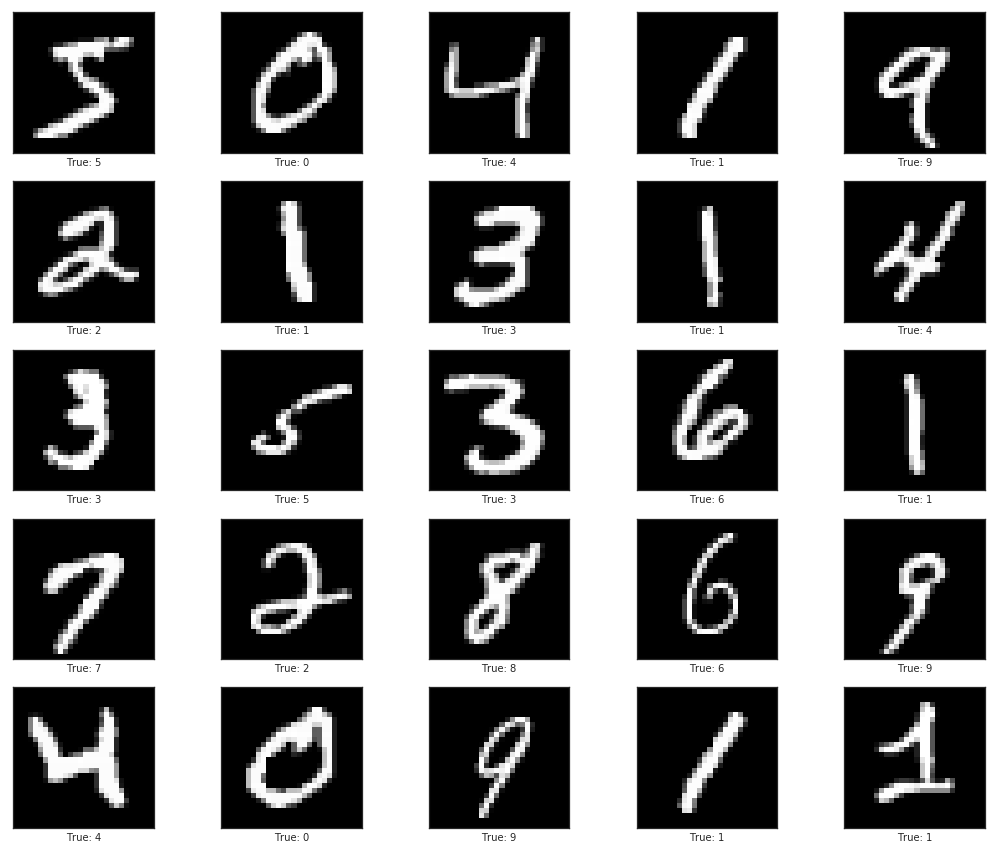

In [9]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

## Set parameter

In [10]:
logging.set_verbosity(logging.INFO)
#logging.set_verbosity(logging.DEBUG)

In [11]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 100

# number of step to train our model
STEPS = 1000

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.data.experimental.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# model name
MODEL_NAME='model_mnist_v1'

# Model Version
MODEL_VERSION = 'v2'

# GCP project name, will be extracted later
PROJECT = ''

# Name of the bucket
BUCKET = 'cloud-training-demos-ml'

# GCP region
REGION = 'us-central1'

# GCP Scale Tier
TIER = 'BASIC'

# Training Directory name
TRAINING_DIR = 'mnist_trained'

# TensforFlow Version
TF_VERSION = '1.12'

# Labels
RESOURCE_LABELS='team=machine-learning,phase=test,owner=fabien'

In [12]:
os.environ['PROJECT'] = subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['BUCKET'] = os.environ['PROJECT']
os.environ['REGION'] = REGION
os.environ['TIER'] = TIER
os.environ['MODEL_NAME'] = MODEL_NAME
os.environ['MODEL_VERSION'] = MODEL_VERSION
os.environ['TRAINING_DIR'] = TRAINING_DIR 
os.environ['TFVERSION'] = TF_VERSION
os.environ['RESOURCE_LABELS'] = RESOURCE_LABELS

## Input dataset
Use tf.data.dataset to feed the Keras model

In [13]:
# be sure you have the tfrecords file locally if you want to train localy (or get them from Cloud Storage)
path_test_tfrecords = 'data/mnist/tfrecords_image_test/*'
path_train_tfrecords = 'data/mnist/tfrecords_image_train/*'

## Defined flags

In [14]:
print(flags.FLAGS)


absl.app:
  --[no]only_check_args: Set to true to validate args and exit.
    (default: 'false')
  --[no]pdb_post_mortem: Set to true to handle uncaught exceptions with PDB post
    mortem.
    (default: 'false')
  --profile_file: Dump profile information to a file (for python -m pstats).
    Implies --run_with_profiling.
  --[no]run_with_pdb: Set to true for PDB debug mode
    (default: 'false')
  --[no]run_with_profiling: Set to true for profiling the script. Execution will
    be slower, and the output format might change over time.
    (default: 'false')
  --[no]use_cprofile_for_profiling: Use cProfile instead of the profile module
    for profiling. This has no effect unless --run_with_profiling is set.
    (default: 'true')

absl.logging:
  --[no]alsologtostderr: also log to stderr?
    (default: 'false')
  --log_dir: directory to write logfiles into
    (default: '')
  --[no]logtostderr: Should only log to stderr?
    (default: 'false')
  --[no]showprefixforinfo: If False, do n

In [15]:
tf_flags=['f', 'input_train_tfrecords', 'input_test_tfrecords', 'model_dir', 'saved_dir', 'epoch', 'step', 'step_per_epoch', 'batch_size', 'shuffle_buffer_size', 'prefetch_buffer_size', 'num_parallel_calls', 'num_classes', 'dim_input']
tensorflow_helper.del_all_flags(flags.FLAGS, tf_flags)

In [16]:
# just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
flags.DEFINE_string('f', '', 'kernel') 

# path to input data
flags.DEFINE_string('input_train_tfrecords', path_train_tfrecords, 'input folder of tfrecords training data')
flags.DEFINE_string('input_test_tfrecords', path_test_tfrecords, 'input folder of tfrecords testing data')


# path to store the model and input for Tensorboard and SavedModel
flags.DEFINE_string('model_dir', 'results/Models/Mnist/tf_1_12/estimator/'+MODEL_VERSION+'/ckpt/', 'Dir to save a model and checkpoints')
flags.DEFINE_string('saved_dir', 'results/Models/Mnist/tf_1_12/estimator/'+MODEL_VERSION+'/pt/', 'Dir to save a model for TF serving')

# parameters for the input dataset and train the model
flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
flags.DEFINE_integer('step', STEPS, 'number of step')
flags.DEFINE_integer('step_per_epoch', len(x_train) // BATCH_SIZE, 'number of step per epoch')
flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')

# parameters for the model
flags.DEFINE_integer('num_classes', NUM_CLASSES, 'number of classes in our model')
flags.DEFINE_integer('dim_input', DIM_INPUT, 'dimension of the input data for our model')

FLAGS = flags.FLAGS

# new with 2.0
FLAGS(sys.argv)

['/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/ipykernel_launcher.py']

In [17]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --dim_input: dimension of the input data for our model
    (default: '784')
    (an integer)
  --epoch: number of epoch
    (default: '100')
    (an integer)
  --f: kernel
    (default: '')
  --input_test_tfrecords: input folder of tfrecords testing data
    (default: 'data/mnist/tfrecords_image_test/*')
  --input_train_tfrecords: input folder of tfrecords training data
    (default: 'data/mnist/tfrecords_image_train/*')
  --model_dir: Dir to save a model and checkpoints
    (default: 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/')
  --num_classes: number of classes in our model
    (default: '10')
    (an integer)
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '-1')
    (an integer)
  --saved_dir: Dir to save a model 

In [18]:
# pre defined flags
tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT, tf.estimator.ModeKeys.TRAIN

('eval', 'infer', 'train')

### Printing the number relater to the number of events (epoch, batch size, ...)

In [19]:
def print_summary_input(data, step='training'):
    print('Summary for the {} dataset:'.format(step))
    if step=='training':
        print('  - number of epoch            :', FLAGS.epoch)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', FLAGS.batch_size)
        print('  - number of step per epoch   :', FLAGS.step_per_epoch)
        print('  - total number of steps      :', FLAGS.epoch * FLAGS.step_per_epoch)
    else:
        print('  - number of epoch            :', 1)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', None)
        print('  - number of step per epoch   :', 1)
        print('  - total number of steps      :', 1)  

In [20]:
print_summary_input(x_train)

Summary for the training dataset:
  - number of epoch            : 100
  - number of events per epoch : 60000
  - batch size                 : 128
  - number of step per epoch   : 468
  - total number of steps      : 46800


In [21]:
print_summary_input(x_test, 'testing')

Summary for the testing dataset:
  - number of epoch            : 1
  - number of events per epoch : 10000
  - batch size                 : None
  - number of step per epoch   : 1
  - total number of steps      : 1


## Machine Learning modelling with Keras

### Deleting existing models
delete fist the folder for a clean start

In [22]:
print('trained model will be saved here:\n', FLAGS.model_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/v2/ckpt/


In [23]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)

In [24]:
print('trained model will be saved here:\n', FLAGS.saved_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/v2/pt/


In [25]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

### Build the model

In [26]:
# reset the model
tf.keras.backend.clear_session()

In [27]:
# build the model
model_opt_tf = mnist_v1.keras_baseline_model(FLAGS.dim_input, FLAGS.num_classes)

# store the origina weights
initial_weights = model_opt_tf.get_weights()

keras_baseline_model


### Check the nuber of parameters

In [28]:
model_opt_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [29]:
model_opt_tf.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [30]:
model_opt_tf.output_names

['dense_2']

### Use tf.distribute.startegy work across multiple devices/machines

In [31]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
# works
strategy=None

# TF 2.0 bug 
# https://github.com/tensorflow/tensorflow/issues/27696
#strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()


# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=1,
                                         save_checkpoints_steps=100,
                                         keep_checkpoint_max=3,
                                         log_step_count_steps=10)

### Transform a keras model to estimator model

In [32]:
# Set to the original weights for testing other pipelines
model_opt_tf.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model_opt_tf,
                                                              config=training_config)

I0418 13:27:52.701709 4643001792 keras.py:464] Using the Keras model provided.
I0418 13:27:53.412559 4643001792 estimator.py:202] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 1, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3ef11748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training and inference using  tf.estimator and tf.data.dataset

- **batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- **steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



### Create some helper function

In [33]:
# need to be migrated to TF 2.0

Input dataset functions for training and testing will be pass during fit to load, convert, preprocess and reshuffle the images and labels 

### Train the  keras to estimator model locally

In [34]:
# drop all files except the keras folder before training
for x in glob.glob(FLAGS.model_dir+'*') :
    if 'keras' not in x:
        os.remove(x)

In [35]:
 for x in glob.glob(FLAGS.model_dir+'*') :
        print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras


In [36]:
%%time
# need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()

# Fit the model (using estimator.train and data.Dataset)
estimator_train_model.train(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_train_tfrecords+'*',
                                                                                     FLAGS,
                                                                                     mode=tf.estimator.ModeKeys.TRAIN,
                                                                                     batch_size=FLAGS.batch_size),
                            steps=1000)

W0418 13:28:51.013942 4643001792 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0418 13:28:51.025806 4643001792 model.py:211] input_dataset_fn: TRAIN, train
I0418 13:28:51.249834 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:28:51.579710 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:28:51.580474 4643001792 estimator.py:1332] Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
I0418 13:28:51.581300 4643001792

I0418 13:28:57.069330 4643001792 basic_session_run_hooks.py:680] global_step/sec: 65.5382
I0418 13:28:57.071290 4643001792 basic_session_run_hooks.py:247] loss = 0.30955225, step = 290 (0.153 sec)
I0418 13:28:57.206571 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 300 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
W0418 13:28:57.276898 4643001792 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/training/saver.py:965: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
I0418 13:28:57.355496 4643001792 basic_session_run_hooks.py:680] global_step/sec: 34.9368
I0418 13:28:57.357114 4643001792 basic_session_run_hooks.py:247] loss = 0.46727735, step = 300 (0.286 sec)
I0418 13:28:57.421781 4643001792 basic_session_run_hooks.py

I0418 13:29:02.749419 4643001792 basic_session_run_hooks.py:680] global_step/sec: 73.9251
I0418 13:29:02.751001 4643001792 basic_session_run_hooks.py:247] loss = 0.2287753, step = 660 (0.135 sec)
I0418 13:29:02.896483 4643001792 basic_session_run_hooks.py:680] global_step/sec: 67.9795
I0418 13:29:02.897664 4643001792 basic_session_run_hooks.py:247] loss = 0.26911896, step = 670 (0.147 sec)
I0418 13:29:03.034888 4643001792 basic_session_run_hooks.py:680] global_step/sec: 72.2664
I0418 13:29:03.036730 4643001792 basic_session_run_hooks.py:247] loss = 0.41031772, step = 680 (0.139 sec)
I0418 13:29:03.180562 4643001792 basic_session_run_hooks.py:680] global_step/sec: 68.6483
I0418 13:29:03.182417 4643001792 basic_session_run_hooks.py:247] loss = 0.37692532, step = 690 (0.146 sec)
I0418 13:29:03.312605 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 700 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0418 13:29:03.471388 4643001792 basic_session_run_hooks.

CPU times: user 45.2 s, sys: 9.38 s, total: 54.6 s
Wall time: 17.3 s


In [37]:
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-900.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-900.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-900.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/events.out.tfevents.1555586931.Fabien-Tarrades-MacBook-Pro.local
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-800.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-800.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-800.data-00000-of-00001


In [38]:
from google.protobuf import text_format


# Let's read our pbtxt file into a Graph protobuf
f = open(FLAGS.model_dir+'graph.pbtxt', "r")
graph_protobuf = text_format.Parse(f.read(), tf.compat.v1.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "global_step"
    }
  }
}
node {
  name: "global_step/IsInitialized/VarIsInitializedOp"
  op: "VarIsInitializedOp"
  input: "global_step"
}
node {
  name: "global_step/Assign"
  op: "AssignVariableOp"
  input: "glo

### Visualize the keras to estimator model train

In [39]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
%tensorboard  --logdir   {FLAGS.model_dir} --port 6020

!kill 84277

In [39]:
# Bug TF 1.12 and TF 2.0
# Issue missing accurary for model to estimator https://github.com/tensorflow/tensorflow/issues/26804

W0418 13:30:21.169009 4643001792 event_accumulator.py:344] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0418 13:30:21.170906 4643001792 event_accumulator.py:352] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
I0418 13:30:21.203073 4643001792 directory_watcher.py:118] No path found after results/Models/Mnist/tf_1_12/estimator/v2/ckpt/events.out.tfevents.1555586931.Fabien-Tarrades-MacBook-Pro.local
W0418 13:30:21.234873 4643001792 legend.py:1289] No handles with labels found to put in legend.




keras
checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-900.meta
model.ckpt-900.data-00000-of-00001
model.ckpt-1000.meta
graph.pbtxt
model.ckpt-900.index
events.out.tfevents.1555586931.Fabien-Tarrades-MacBook-Pro.local
model.ckpt-800.index
model.ckpt-800.meta
model.ckpt-1000.index
model.ckpt-800.data-00000-of-00001


dict_keys(['global_step/sec', 'loss_1'])




Loss:
  - loss [training dataset]: 0.089

Accuracy:


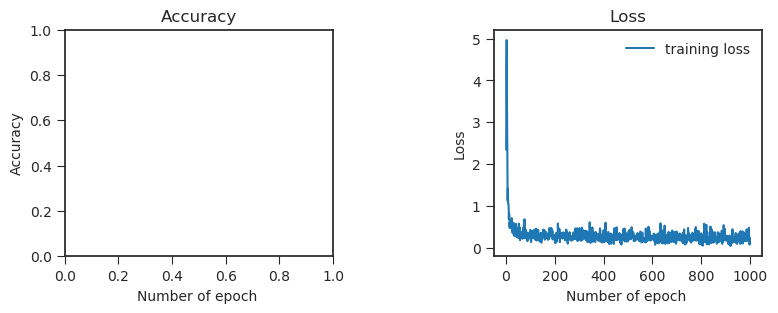

In [40]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss_1'][0],history_train['loss_1'][1])

### Evaluate the  keras to estimator model locally

In [41]:
metric=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_test_tfrecords+'*',
                                                                                               FLAGS,
                                                                                               mode=tf.estimator.ModeKeys.EVAL,
                                                                                               batch_size=10000),
                                      steps=1),

I0418 13:30:55.457109 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:30:55.502958 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:30:55.650047 4643001792 estimator.py:1128] Done calling model_fn.
W0418 13:30:55.650941 4643001792 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/ops/metrics_impl.py:363: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
I0418 13:30:55.683865 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:30:55Z
I0418 13:30:55.768962 4643001792 monitored_session.py:241] Graph was finalized.
W0418 13:30:55.770455 4643001792 deprecation.py:323] From /Users/tarrade/anaconda3/envs/env_gcp_dl_2_0_alpha/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and 

In [42]:
metric

({'accuracy': 0.9561, 'loss': 0.16188705, 'global_step': 1000},)

### Train and evaluate the  keras to estimator model locally

In [43]:
#%%time
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

# chcking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

    # need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()
# Reset Keras
tf.keras.backend.clear_session()
# Fit the model (using estimator.train and data.Dataset)
mnist_v1.train_and_evaluate(FLAGS, use_keras=True)

I0418 13:31:51.548840 4643001792 keras.py:464] Using the Keras model provided.


using keras model in estimator
keras_baseline_model


I0418 13:31:52.233834 4643001792 estimator.py:202] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c38d34cf8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
I0418 13:31:52.234966 4643001792 estimator_training.py:186] Not using Distribute Coordinator.
I0418 13:31:52.235888 46

I0418 13:32:00.331439 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:32:00
I0418 13:32:00.332468 4643001792 estimator.py:2027] Saving dict for global step 40: accuracy = 0.9127, global_step = 40, loss = 0.29391345
I0418 13:32:00.334413 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 40: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-40
I0418 13:32:00.451623 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 50 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0418 13:32:00.579130 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:32:00.623322 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:32:00.751738 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:32:00.781616 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:32:00Z
I0418 13:32:00.873342 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:32:00.876422 4643001792 saver.py:1280] 

I0418 13:32:10.297996 4643001792 estimator.py:2027] Saving dict for global step 100: accuracy = 0.9352, global_step = 100, loss = 0.21815877
I0418 13:32:10.299745 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 100: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-100
I0418 13:32:10.311808 4643001792 basic_session_run_hooks.py:680] global_step/sec: 5.96187
I0418 13:32:10.313621 4643001792 basic_session_run_hooks.py:247] loss = 0.36432105, step = 100 (8.387 sec)
I0418 13:32:10.384204 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 110 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0418 13:32:10.501027 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:32:10.543781 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:32:10.670484 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:32:10.701282 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:32:10Z
I0418 13:32:10.784150

I0418 13:32:20.961688 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:32:20
I0418 13:32:20.962480 4643001792 estimator.py:2027] Saving dict for global step 160: accuracy = 0.9429, global_step = 160, loss = 0.19405493
I0418 13:32:20.963909 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 160: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-160
I0418 13:32:21.060494 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 170 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0418 13:32:21.179254 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:32:21.221628 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:32:21.344666 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:32:21.372555 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:32:21Z
I0418 13:32:21.454300 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:32:21.456446 4643001792 saver.py:1

I0418 13:32:31.211681 4643001792 estimator.py:2027] Saving dict for global step 220: accuracy = 0.9382, global_step = 220, loss = 0.19250312
I0418 13:32:31.213088 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 220: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-220
I0418 13:32:31.310837 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 230 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0418 13:32:31.428401 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:32:31.469923 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:32:31.592581 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:32:31.625719 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:32:31Z
I0418 13:32:31.715497 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:32:31.717525 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-230
I0

I0418 13:32:41.457340 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 280: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-280
I0418 13:32:41.545165 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 290 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0418 13:32:41.668083 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:32:41.713745 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:32:41.835611 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:32:41.863311 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:32:41Z
I0418 13:32:41.945488 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:32:41.947663 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-290
I0418 13:32:41.980233 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:32:41.991133 4643001792 session_manager.py:502] Done r

I0418 13:32:52.107301 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 350 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0418 13:32:52.248085 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:32:52.294170 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:32:52.440144 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:32:52.478060 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:32:52Z
I0418 13:32:52.578474 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:32:52.580384 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-350
I0418 13:32:52.614735 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:32:52.624864 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:32:53.672353 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:32:53.693650 4643001792 evaluation.py:277] Finished evaluation at 20

I0418 13:33:02.607588 4643001792 basic_session_run_hooks.py:247] loss = 0.22181314, step = 400 (8.896 sec)
I0418 13:33:02.672006 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 410 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0418 13:33:02.808295 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:33:02.857659 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:33:03.002691 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:33:03.391759 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:33:03Z
I0418 13:33:03.480662 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:33:03.482469 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-410
I0418 13:33:03.518388 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:33:03.530032 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:33:05.162136 4643001792 evalua

I0418 13:33:14.710484 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 470 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0418 13:33:14.863417 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:33:14.912220 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:33:15.064504 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:33:15.095387 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:33:15Z
I0418 13:33:15.183067 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:33:15.185391 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-470
I0418 13:33:15.219100 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:33:15.230206 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:33:16.418085 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:33:16.438029 4643001792 evaluation.py:277] Finished evaluation at 20

I0418 13:33:25.784468 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:33:25.826667 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:33:25.970662 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:33:26.000520 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:33:26Z
I0418 13:33:26.084815 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:33:26.086764 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-530
I0418 13:33:26.118269 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:33:26.132822 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:33:27.306113 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:33:27.326529 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:33:27
I0418 13:33:27.327522 4643001792 estimator.py:2027] Saving dict for global step 530: accuracy = 0.9549, global_step = 530, loss = 0.157320

I0418 13:33:37.394939 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:33:37.527420 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:33:37.557719 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:33:37Z
I0418 13:33:37.649837 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:33:37.652151 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-590
I0418 13:33:37.687325 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:33:37.699107 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:33:38.919327 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:33:38.937727 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:33:38
I0418 13:33:38.938563 4643001792 estimator.py:2027] Saving dict for global step 590: accuracy = 0.9502, global_step = 590, loss = 0.1664213
I0418 13:33:38.940341 4643001792 estimator.py:2087] Saving 'checkpoint_pat

I0418 13:33:49.312716 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:33:49.346907 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:33:49Z
I0418 13:33:49.441018 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:33:49.443180 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-650
I0418 13:33:49.480077 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:33:49.492330 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:33:50.807748 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:33:50.831448 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:33:50
I0418 13:33:50.832176 4643001792 estimator.py:2027] Saving dict for global step 650: accuracy = 0.9516, global_step = 650, loss = 0.16445102
I0418 13:33:50.833786 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 650: results/Models/Mnist/tf_1_12/estimato

I0418 13:34:01.702320 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0418 13:34:01.753535 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:34:01.903161 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:34:01.943188 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:34:01Z
I0418 13:34:02.041369 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:34:02.043834 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-710
I0418 13:34:02.079977 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:34:02.092627 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:34:03.372442 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:34:03.391461 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:34:03
I0418 13:34:03.392463 4643001792 estimator.py:2027] Saving dict for global step 710: accuracy = 0.95, global_step = 710, loss = 0.17297436

I0418 13:34:13.538151 4643001792 estimator.py:1126] Calling model_fn.
I0418 13:34:13.692706 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:34:13.728770 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:34:13Z
I0418 13:34:13.833050 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:34:13.835930 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-770
I0418 13:34:13.875600 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:34:13.888176 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:34:15.366642 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:34:15.390165 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:34:15
I0418 13:34:15.391165 4643001792 estimator.py:2027] Saving dict for global step 770: accuracy = 0.95, global_step = 770, loss = 0.18142392
I0418 13:34:15.393263 4643001792 estimator.py:2087] Saving 'checkpoint_path

I0418 13:34:26.072633 4643001792 estimator.py:1128] Done calling model_fn.
I0418 13:34:26.109128 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:34:26Z
I0418 13:34:26.223429 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:34:26.225708 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-830
I0418 13:34:26.266748 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:34:26.278901 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:34:27.719000 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:34:27.736904 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:34:27
I0418 13:34:27.737904 4643001792 estimator.py:2027] Saving dict for global step 830: accuracy = 0.9503, global_step = 830, loss = 0.18560025
I0418 13:34:27.739924 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 830: results/Models/Mnist/tf_1_12/estimato

I0418 13:34:38.745754 4643001792 evaluation.py:257] Starting evaluation at 2019-04-18T11:34:38Z
I0418 13:34:38.847897 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:34:38.851072 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-890
I0418 13:34:38.890989 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:34:38.905280 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:34:40.401015 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:34:40.422525 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:34:40
I0418 13:34:40.423712 4643001792 estimator.py:2027] Saving dict for global step 890: accuracy = 0.9565, global_step = 890, loss = 0.15334347
I0418 13:34:40.426065 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 890: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-890
I0418 13:34:40.532647 4643001792 basic_session_run

I0418 13:34:52.083210 4643001792 monitored_session.py:241] Graph was finalized.
I0418 13:34:52.085887 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-950
I0418 13:34:52.126317 4643001792 session_manager.py:500] Running local_init_op.
I0418 13:34:52.137578 4643001792 session_manager.py:502] Done running local_init_op.
I0418 13:34:53.515105 4643001792 evaluation.py:169] Evaluation [1/1]
I0418 13:34:53.535497 4643001792 evaluation.py:277] Finished evaluation at 2019-04-18-11:34:53
I0418 13:34:53.536237 4643001792 estimator.py:2027] Saving dict for global step 950: accuracy = 0.9561, global_step = 950, loss = 0.15735616
I0418 13:34:53.537765 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 950: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-950
I0418 13:34:53.552388 4643001792 basic_session_run_hooks.py:680] global_step/sec: 4.82931
I0418 13:34:53.555076 4643001792 basic_session_run_hooks

In [44]:
# checking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/keras
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.index


### Visualize the keras to estimator model train/eval

In [45]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
%tensorboard  --logdir   {FLAGS.model_dir} --port 6022

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [51]:
from google.protobuf import text_format


# Let's read our pbtxt file into a Graph protobuf
f = open(FLAGS.model_dir+'graph.pbtxt', "r")
graph_protobuf = text_format.Parse(f.read(), tf.compat.v1.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "global_step"
    }
  }
}
node {
  name: "global_step/IsInitialized/VarIsInitializedOp"
  op: "VarIsInitializedOp"
  input: "global_step"
}
node {
  name: "global_step/Assign"
  op: "AssignVariableOp"
  input: "glo

In [52]:
# Bug TF 2.0, no events produced
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
#history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_train)
    #print(history_eval.keys())
    #print('number of entry for train:', len(history_train['loss_1']))
    #print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
#ml_utils.plot_acc_loss(None, None,
#                       None, None,
#                       history_eval['loss'][0],history_eval['loss'][1],
#                       history_eval['accuracy'][0],history_eval['accuracy'][1])



keras
checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.meta
model.ckpt-990.index
graph.pbtxt
model.ckpt-990.data-00000-of-00001
model.ckpt-980.meta
model.ckpt-990.meta
model.ckpt-980.data-00000-of-00001
model.ckpt-980.index
model.ckpt-1000.index


dict_keys([])
{}






### Predict using the  keras to estimator model locally

### Train and evaluate the estimator model with keras layers locally

In [112]:
%%time
# Bug TF 2.0
# comment out exporter because of thie issue https://github.com/tensorflow/tensorflow/issues/27345

logging.set_verbosity(logging.INFO)
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)
# need if file are removed with previous event files
#tf.summary.FileWriterCache.clear()
# Reset Keras
tf.keras.backend.clear_session()

# Fit the model (using estimator.train and data.Dataset)
mnist_v1.train_and_evaluate(FLAGS, use_keras=False)

logging.set_verbosity(logging.INFO)

I0423 16:02:43.914738 4643001792 estimator.py:202] Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/v2/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c64e02358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
I0423 16:02:43.918018 4643001792 estimator_training.py:186] Not using Distribute Coordinator.
I0423 16:02:43.919104 46

using keras layer and estimator (recommended way)
model based on keras layer but return an estimator model
step 7


I0423 16:02:44.704667 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:02:44.717285 4643001792 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


step 8


I0423 16:02:44.914345 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:02:45.281585 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:02:45.296872 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:02:45.709418 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 0 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0423 16:02:46.816443 4643001792 basic_session_run_hooks.py:249] loss = 2.3079166, step = 0
I0423 16:02:47.110539 4643001792 basic_session_run_hooks.py:594] Saving checkpoints for 10 into results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt.
I0423 16:02:47.278764 4643001792 model.py:209] input_dataset_fn: EVAL, eval
I0423 16:02:47.336808 4643001792 estimator.py:1126] Calling model_fn.


model based on keras layer but return an estimator model


I0423 16:02:47.575689 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:02:47.629925 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:02:47Z
I0423 16:02:47.762699 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:02:47.768001 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-10
I0423 16:02:47.820730 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:02:47.834795 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:02:49.952605 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:02:49.974618 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:02:49
I0423 16:02:49.976758 4643001792 estimator.py:2027] Saving dict for global step 10: accuracy = 0.6349, global_step = 10, loss = 1.8894418
I0423 16:02:49.986555 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 10: results/Models/Mnist/tf_1_12/estimator/v2/

model based on keras layer but return an estimator model


I0423 16:02:50.808359 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:02:50.843014 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:02:50Z
I0423 16:02:50.951589 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:02:50.956238 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-20
I0423 16:02:51.013400 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:02:51.030189 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:02:53.072992 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:02:53.092103 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:02:53
I0423 16:02:53.092861 4643001792 estimator.py:2027] Saving dict for global step 20: accuracy = 0.7462, global_step = 20, loss = 1.7379148
I0423 16:02:53.094061 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 20: results/Models/Mnist/tf_1_12/estimator/v2/

model based on keras layer but return an estimator model


I0423 16:02:53.701803 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:02:53Z
I0423 16:02:53.809014 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:02:53.811171 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-30
I0423 16:02:53.855881 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:02:53.866800 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:02:55.639113 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:02:55.654696 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:02:55
I0423 16:02:55.655579 4643001792 estimator.py:2027] Saving dict for global step 30: accuracy = 0.8589, global_step = 30, loss = 1.62637
I0423 16:02:55.657617 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 30: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-30
I0423 16:02:55.797349 4643001792 basic_session_run_hooks.p

model based on keras layer but return an estimator model


I0423 16:02:56.255546 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:02:56Z
I0423 16:02:56.350566 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:02:56.354291 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-40
I0423 16:02:56.401761 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:02:56.413336 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:02:58.196074 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:02:58.213063 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:02:58
I0423 16:02:58.214317 4643001792 estimator.py:2027] Saving dict for global step 40: accuracy = 0.8806, global_step = 40, loss = 1.5975145
I0423 16:02:58.215872 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 40: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-40
I0423 16:02:58.338238 4643001792 basic_session_run_hooks

model based on keras layer but return an estimator model


I0423 16:02:58.750734 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:02:58Z
I0423 16:02:58.831001 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:02:58.834789 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-50
I0423 16:02:58.874871 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:02:58.886124 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:00.683333 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:00.702208 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:00
I0423 16:03:00.702934 4643001792 estimator.py:2027] Saving dict for global step 50: accuracy = 0.8894, global_step = 50, loss = 1.5844793
I0423 16:03:00.705328 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 50: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-50
I0423 16:03:00.731837 4643001792 basic_session_run_hooks

model based on keras layer but return an estimator model


I0423 16:03:01.315505 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:14.960037 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:14Z
I0423 16:03:15.066282 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:15.070472 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-60
I0423 16:03:15.128695 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:15.143759 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:16.105741 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:16.127928 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:16
I0423 16:03:16.128708 4643001792 estimator.py:2027] Saving dict for global step 60: accuracy = 0.8968, global_step = 60, loss = 1.5749629
I0423 16:03:16.130150 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 60: results/Models/Mnist/tf_1_12/estimator/v2/

model based on keras layer but return an estimator model


I0423 16:03:16.699425 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:16Z
I0423 16:03:16.798341 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:16.801295 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-70
I0423 16:03:16.847230 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:16.861504 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:18.035261 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:18.058222 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:18
I0423 16:03:18.059406 4643001792 estimator.py:2027] Saving dict for global step 70: accuracy = 0.913, global_step = 70, loss = 1.5580685
I0423 16:03:18.060548 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 70: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-70
I0423 16:03:18.181500 4643001792 basic_session_run_hooks.

model based on keras layer but return an estimator model


I0423 16:03:18.609617 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:18Z
I0423 16:03:18.725652 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:18.727696 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-80
I0423 16:03:18.770362 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:18.784645 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:19.957379 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:19.979372 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:19
I0423 16:03:19.980148 4643001792 estimator.py:2027] Saving dict for global step 80: accuracy = 0.9007, global_step = 80, loss = 1.5682788
I0423 16:03:19.981094 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 80: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-80
I0423 16:03:20.085927 4643001792 basic_session_run_hooks

model based on keras layer but return an estimator model


I0423 16:03:20.538542 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:20Z
I0423 16:03:20.634199 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:20.638360 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-90
I0423 16:03:20.679571 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:20.692380 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:21.662420 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:21.681601 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:21
I0423 16:03:21.682532 4643001792 estimator.py:2027] Saving dict for global step 90: accuracy = 0.9085, global_step = 90, loss = 1.559751
I0423 16:03:21.684485 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 90: results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-90
I0423 16:03:21.801926 4643001792 basic_session_run_hooks.

model based on keras layer but return an estimator model


I0423 16:03:22.246908 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:22.292272 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:22Z
I0423 16:03:22.789602 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:22.794162 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-100
I0423 16:03:22.833110 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:22.847290 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:23.945456 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:23.965232 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:23
I0423 16:03:23.966571 4643001792 estimator.py:2027] Saving dict for global step 100: accuracy = 0.9102, global_step = 100, loss = 1.5579666
I0423 16:03:23.968232 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 100: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:24.511164 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:24.546041 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:24Z
I0423 16:03:24.650151 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:24.655055 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-110
I0423 16:03:24.695835 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:24.709669 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:25.811824 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:25.831347 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:25
I0423 16:03:25.832313 4643001792 estimator.py:2027] Saving dict for global step 110: accuracy = 0.9196, global_step = 110, loss = 1.5472432
I0423 16:03:25.833419 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 110: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:26.405378 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:26.446672 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:26Z
I0423 16:03:26.560290 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:26.562757 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-120
I0423 16:03:26.609473 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:26.622629 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:27.695700 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:27.715578 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:27
I0423 16:03:27.716448 4643001792 estimator.py:2027] Saving dict for global step 120: accuracy = 0.9233, global_step = 120, loss = 1.5441767
I0423 16:03:27.719112 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 120: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:28.268682 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:28.306629 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:28Z
I0423 16:03:28.421798 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:28.427120 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-130
I0423 16:03:28.478980 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:28.496990 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:29.600137 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:29.621717 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:29
I0423 16:03:29.623935 4643001792 estimator.py:2027] Saving dict for global step 130: accuracy = 0.9252, global_step = 130, loss = 1.5405772
I0423 16:03:29.627761 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 130: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:30.212676 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:30.249140 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:30Z
I0423 16:03:30.369096 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:30.374413 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-140
I0423 16:03:30.419203 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:30.434637 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:31.602377 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:31.625473 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:31
I0423 16:03:31.626837 4643001792 estimator.py:2027] Saving dict for global step 140: accuracy = 0.9315, global_step = 140, loss = 1.535677
I0423 16:03:31.628702 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 140: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:03:32.227781 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:32.662741 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:32Z
I0423 16:03:32.785426 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:32.791254 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-150
I0423 16:03:32.841806 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:32.861253 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:34.167690 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:34.192591 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:34
I0423 16:03:34.194511 4643001792 estimator.py:2027] Saving dict for global step 150: accuracy = 0.9275, global_step = 150, loss = 1.5396584
I0423 16:03:34.196429 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 150: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:34.805099 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:34.856436 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:34Z
I0423 16:03:34.979207 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:34.981798 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-160
I0423 16:03:35.030874 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:35.046113 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:36.322661 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:36.348510 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:36
I0423 16:03:36.349457 4643001792 estimator.py:2027] Saving dict for global step 160: accuracy = 0.9311, global_step = 160, loss = 1.5357695
I0423 16:03:36.351365 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 160: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:36.965631 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:37.011738 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:37Z
I0423 16:03:37.131750 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:37.134411 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-170
I0423 16:03:37.186580 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:37.203795 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:38.537358 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:38.564856 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:38
I0423 16:03:38.565955 4643001792 estimator.py:2027] Saving dict for global step 170: accuracy = 0.934, global_step = 170, loss = 1.5319346
I0423 16:03:38.568165 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 170: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:03:39.185333 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:39.230730 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:39Z
I0423 16:03:39.364663 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:39.366970 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-180
I0423 16:03:39.416703 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:39.433408 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:40.774227 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:40.797937 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:40
I0423 16:03:40.799058 4643001792 estimator.py:2027] Saving dict for global step 180: accuracy = 0.9322, global_step = 180, loss = 1.5334222
I0423 16:03:40.802341 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 180: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:41.396544 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:41.436140 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:41Z
I0423 16:03:41.558649 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:41.563072 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-190
I0423 16:03:41.614454 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:41.629971 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:43.013861 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:43.035096 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:43
I0423 16:03:43.036113 4643001792 estimator.py:2027] Saving dict for global step 190: accuracy = 0.9295, global_step = 190, loss = 1.5372018
I0423 16:03:43.037702 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 190: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:43.659620 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:43.703933 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:43Z
I0423 16:03:43.844382 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:43.848758 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-200
I0423 16:03:43.901609 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:43.921831 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:45.177841 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:45.199246 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:45
I0423 16:03:45.200100 4643001792 estimator.py:2027] Saving dict for global step 200: accuracy = 0.9374, global_step = 200, loss = 1.5273896
I0423 16:03:45.201787 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 200: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:45.809242 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:45.849261 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:45Z
I0423 16:03:46.425780 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:46.429466 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-210
I0423 16:03:46.480163 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:46.496142 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:47.800724 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:47.821352 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:47
I0423 16:03:47.822650 4643001792 estimator.py:2027] Saving dict for global step 210: accuracy = 0.9316, global_step = 210, loss = 1.5341387
I0423 16:03:47.825868 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 210: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:48.418993 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:48.454582 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:48Z
I0423 16:03:48.570853 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:48.576944 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-220
I0423 16:03:48.620252 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:48.635044 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:49.759177 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:49.784337 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:49
I0423 16:03:49.785485 4643001792 estimator.py:2027] Saving dict for global step 220: accuracy = 0.9311, global_step = 220, loss = 1.5325832
I0423 16:03:49.787567 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 220: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:50.341400 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:50.378504 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:50Z
I0423 16:03:50.486519 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:50.489082 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-230
I0423 16:03:50.533992 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:50.548182 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:51.606701 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:51.629812 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:51
I0423 16:03:51.630982 4643001792 estimator.py:2027] Saving dict for global step 230: accuracy = 0.9313, global_step = 230, loss = 1.5334185
I0423 16:03:51.632621 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 230: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:52.176976 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:52.219161 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:52Z
I0423 16:03:52.326719 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:52.330770 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-240
I0423 16:03:52.378227 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:52.398299 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:53.581964 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:53.601528 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:53
I0423 16:03:53.602474 4643001792 estimator.py:2027] Saving dict for global step 240: accuracy = 0.9354, global_step = 240, loss = 1.5281734
I0423 16:03:53.603990 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 240: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:54.196774 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:54.236004 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:54Z
I0423 16:03:54.359426 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:54.363373 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-250
I0423 16:03:54.418758 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:54.434532 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:55.788877 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:55.819612 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:55
I0423 16:03:55.820858 4643001792 estimator.py:2027] Saving dict for global step 250: accuracy = 0.9401, global_step = 250, loss = 1.5248697
I0423 16:03:55.824209 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 250: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:56.438010 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:56.482162 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:56Z
I0423 16:03:56.598678 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:56.600992 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-260
I0423 16:03:56.649136 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:56.664022 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:03:57.903228 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:03:57.925668 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:03:57
I0423 16:03:57.927955 4643001792 estimator.py:2027] Saving dict for global step 260: accuracy = 0.9385, global_step = 260, loss = 1.5265315
I0423 16:03:57.931488 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 260: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:03:58.497524 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:03:58.537763 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:03:58Z
I0423 16:03:58.650219 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:03:58.652933 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-270
I0423 16:03:58.700976 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:03:58.714862 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:00.071344 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:00.098547 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:00
I0423 16:04:00.100015 4643001792 estimator.py:2027] Saving dict for global step 270: accuracy = 0.9408, global_step = 270, loss = 1.5236268
I0423 16:04:00.102314 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 270: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:00.813309 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:00.867291 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:00Z
I0423 16:04:00.996029 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:00.999521 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-280
I0423 16:04:01.051514 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:01.067466 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:02.456026 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:02.482955 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:02
I0423 16:04:02.484165 4643001792 estimator.py:2027] Saving dict for global step 280: accuracy = 0.9417, global_step = 280, loss = 1.5226157
I0423 16:04:02.486100 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 280: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:03.712556 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:03.752644 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:03Z
I0423 16:04:03.871107 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:03.873766 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-290
I0423 16:04:03.922374 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:03.942790 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:05.461211 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:05.490300 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:05
I0423 16:04:05.493391 4643001792 estimator.py:2027] Saving dict for global step 290: accuracy = 0.9464, global_step = 290, loss = 1.5180273
I0423 16:04:05.498222 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 290: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:06.237801 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:06.284409 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:06Z
I0423 16:04:06.407698 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:06.412249 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-300
I0423 16:04:06.463882 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:06.479878 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:08.002352 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:08.023512 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:08
I0423 16:04:08.024981 4643001792 estimator.py:2027] Saving dict for global step 300: accuracy = 0.9465, global_step = 300, loss = 1.517833
I0423 16:04:08.028455 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 300: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:04:08.708592 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:08.754060 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:08Z
I0423 16:04:08.885048 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:08.887952 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-310
I0423 16:04:08.941139 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:08.964453 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:10.510207 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:10.534991 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:10
I0423 16:04:10.535896 4643001792 estimator.py:2027] Saving dict for global step 310: accuracy = 0.9442, global_step = 310, loss = 1.5206693
I0423 16:04:10.537701 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 310: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:11.166214 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:11.208384 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:11Z
I0423 16:04:11.335874 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:11.338348 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-320
I0423 16:04:11.388836 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:11.405549 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:12.932459 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:12.954226 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:12
I0423 16:04:12.955142 4643001792 estimator.py:2027] Saving dict for global step 320: accuracy = 0.9473, global_step = 320, loss = 1.5166526
I0423 16:04:12.957161 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 320: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:13.583611 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:13.623909 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:13Z
I0423 16:04:13.743093 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:13.747464 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-330
I0423 16:04:13.800638 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:13.816220 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:15.338001 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:15.358144 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:15
I0423 16:04:15.359216 4643001792 estimator.py:2027] Saving dict for global step 330: accuracy = 0.9481, global_step = 330, loss = 1.5159903
I0423 16:04:15.362787 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 330: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:16.010447 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:16.065525 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:16Z
I0423 16:04:16.211362 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:16.218218 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-340
I0423 16:04:16.274768 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:16.293619 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:17.875755 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:17.901581 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:17
I0423 16:04:17.902889 4643001792 estimator.py:2027] Saving dict for global step 340: accuracy = 0.9475, global_step = 340, loss = 1.5172057
I0423 16:04:17.904794 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 340: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:18.553902 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:18.599695 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:18Z
I0423 16:04:18.727098 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:18.731359 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-350
I0423 16:04:18.783775 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:18.800607 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:20.601216 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:20.623358 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:20
I0423 16:04:20.624379 4643001792 estimator.py:2027] Saving dict for global step 350: accuracy = 0.9424, global_step = 350, loss = 1.5210717
I0423 16:04:20.627048 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 350: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:21.295149 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:21.341398 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:21Z
I0423 16:04:21.462430 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:21.466944 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-360
I0423 16:04:21.520993 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:21.537976 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:23.184051 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:23.207679 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:23
I0423 16:04:23.209167 4643001792 estimator.py:2027] Saving dict for global step 360: accuracy = 0.9459, global_step = 360, loss = 1.5185069
I0423 16:04:23.211977 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 360: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:23.864661 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:23.911870 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:23Z
I0423 16:04:24.048847 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:24.052829 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-370
I0423 16:04:24.107508 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:24.125372 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:25.783720 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:25.807060 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:25
I0423 16:04:25.808026 4643001792 estimator.py:2027] Saving dict for global step 370: accuracy = 0.9477, global_step = 370, loss = 1.5167365
I0423 16:04:25.809584 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 370: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:26.446642 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:27.260155 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:27Z
I0423 16:04:27.419474 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:27.422048 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-380
I0423 16:04:27.476063 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:27.498362 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:29.252338 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:29.275950 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:29
I0423 16:04:29.277344 4643001792 estimator.py:2027] Saving dict for global step 380: accuracy = 0.9465, global_step = 380, loss = 1.5171899
I0423 16:04:29.281259 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 380: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:29.995902 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:30.044853 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:30Z
I0423 16:04:30.199270 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:30.203535 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-390
I0423 16:04:30.258322 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:30.276036 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:32.158104 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:32.190778 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:32
I0423 16:04:32.191915 4643001792 estimator.py:2027] Saving dict for global step 390: accuracy = 0.9434, global_step = 390, loss = 1.5198112
I0423 16:04:32.193796 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 390: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:32.922067 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:32.978362 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:32Z
I0423 16:04:33.133829 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:33.136665 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-400
I0423 16:04:33.191511 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:33.209602 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:34.997936 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:35.024925 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:35
I0423 16:04:35.026000 4643001792 estimator.py:2027] Saving dict for global step 400: accuracy = 0.9481, global_step = 400, loss = 1.5161427
I0423 16:04:35.028310 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 400: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:35.792619 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:35.841536 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:35Z
I0423 16:04:35.989948 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:35.993178 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-410
I0423 16:04:36.054893 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:36.074245 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:38.043786 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:38.077967 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:38
I0423 16:04:38.080176 4643001792 estimator.py:2027] Saving dict for global step 410: accuracy = 0.9461, global_step = 410, loss = 1.5170863
I0423 16:04:38.083887 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 410: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:38.972450 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:39.023828 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:39Z
I0423 16:04:39.173722 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:39.177489 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-420
I0423 16:04:39.241530 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:39.262277 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:41.425700 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:41.451390 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:41
I0423 16:04:41.453029 4643001792 estimator.py:2027] Saving dict for global step 420: accuracy = 0.9505, global_step = 420, loss = 1.5125347
I0423 16:04:41.455340 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 420: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:42.209846 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:42.265638 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:42Z
I0423 16:04:42.420011 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:42.423105 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-430
I0423 16:04:42.479810 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:42.499782 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:44.597198 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:44.626234 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:44
I0423 16:04:44.627860 4643001792 estimator.py:2027] Saving dict for global step 430: accuracy = 0.9501, global_step = 430, loss = 1.5132543
I0423 16:04:44.630141 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 430: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:45.454138 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:45.509328 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:45Z
I0423 16:04:45.672151 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:45.675242 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-440
I0423 16:04:45.735267 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:45.754852 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:47.811160 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:47.841754 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:47
I0423 16:04:47.843873 4643001792 estimator.py:2027] Saving dict for global step 440: accuracy = 0.9506, global_step = 440, loss = 1.5127699
I0423 16:04:47.846122 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 440: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:48.711168 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:48.760698 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:48Z
I0423 16:04:48.912200 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:48.916049 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-450
I0423 16:04:48.980777 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:49.002874 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:51.025547 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:51.053003 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:51
I0423 16:04:51.054725 4643001792 estimator.py:2027] Saving dict for global step 450: accuracy = 0.9505, global_step = 450, loss = 1.5129879
I0423 16:04:51.057585 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 450: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:51.843255 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:51.897726 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:51Z
I0423 16:04:52.051258 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:52.056101 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-460
I0423 16:04:52.114192 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:52.134693 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:54.381883 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:54.410346 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:54
I0423 16:04:54.411875 4643001792 estimator.py:2027] Saving dict for global step 460: accuracy = 0.9508, global_step = 460, loss = 1.5123571
I0423 16:04:54.415027 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 460: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:04:55.260833 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:55.315983 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:55Z
I0423 16:04:55.486974 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:55.490367 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-470
I0423 16:04:55.555514 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:55.576106 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:04:57.847189 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:04:57.882292 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:04:57
I0423 16:04:57.884972 4643001792 estimator.py:2027] Saving dict for global step 470: accuracy = 0.9535, global_step = 470, loss = 1.509965
I0423 16:04:57.890522 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 470: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:04:58.854877 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:04:58.910732 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:04:58Z
I0423 16:04:59.073488 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:04:59.077064 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-480
I0423 16:04:59.141861 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:04:59.162343 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:01.727564 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:01.757744 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:01
I0423 16:05:01.759403 4643001792 estimator.py:2027] Saving dict for global step 480: accuracy = 0.9556, global_step = 480, loss = 1.5079468
I0423 16:05:01.762502 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 480: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:02.540776 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:02.593667 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:02Z
I0423 16:05:02.761923 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:02.765509 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-490
I0423 16:05:02.843878 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:02.867312 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:05.083045 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:05.112680 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:05
I0423 16:05:05.114366 4643001792 estimator.py:2027] Saving dict for global step 490: accuracy = 0.9525, global_step = 490, loss = 1.5104969
I0423 16:05:05.116252 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 490: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:06.842530 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:06.903126 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:06Z
I0423 16:05:07.069308 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:07.073804 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-500
I0423 16:05:07.138324 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:07.161048 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:09.539846 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:09.569213 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:09
I0423 16:05:09.572577 4643001792 estimator.py:2027] Saving dict for global step 500: accuracy = 0.9507, global_step = 500, loss = 1.512701
I0423 16:05:09.576836 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 500: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:05:10.389653 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:10.442841 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:10Z
I0423 16:05:10.601153 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:10.606292 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-510
I0423 16:05:10.670257 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:10.691898 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:12.883903 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:12.913437 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:12
I0423 16:05:12.914605 4643001792 estimator.py:2027] Saving dict for global step 510: accuracy = 0.9545, global_step = 510, loss = 1.5084828
I0423 16:05:12.916269 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 510: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:13.731194 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:13.784850 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:13Z
I0423 16:05:13.944978 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:13.948901 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-520
I0423 16:05:14.018877 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:14.041471 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:16.301758 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:16.332738 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:16
I0423 16:05:16.334056 4643001792 estimator.py:2027] Saving dict for global step 520: accuracy = 0.9501, global_step = 520, loss = 1.5141722
I0423 16:05:16.338147 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 520: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:17.144534 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:17.197680 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:17Z
I0423 16:05:17.360758 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:17.364474 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-530
I0423 16:05:17.429746 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:17.449857 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:19.885254 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:19.914319 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:19
I0423 16:05:19.916155 4643001792 estimator.py:2027] Saving dict for global step 530: accuracy = 0.948, global_step = 530, loss = 1.5142733
I0423 16:05:19.918872 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 530: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:05:20.734618 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:20.788990 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:20Z
I0423 16:05:20.951800 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:20.957638 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-540
I0423 16:05:21.029701 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:21.052014 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:23.473583 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:23.506999 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:23
I0423 16:05:23.509244 4643001792 estimator.py:2027] Saving dict for global step 540: accuracy = 0.9562, global_step = 540, loss = 1.5075926
I0423 16:05:23.512038 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 540: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:24.392257 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:24.449939 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:24Z
I0423 16:05:24.626246 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:24.631281 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-550
I0423 16:05:24.702417 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:24.726855 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:27.192863 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:27.224585 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:27
I0423 16:05:27.226824 4643001792 estimator.py:2027] Saving dict for global step 550: accuracy = 0.9529, global_step = 550, loss = 1.5107144
I0423 16:05:27.230715 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 550: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:28.169968 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:28.240231 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:28Z
I0423 16:05:28.439295 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:28.447458 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-560
I0423 16:05:28.531482 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:28.557239 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:30.998768 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:31.030411 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:31
I0423 16:05:31.031732 4643001792 estimator.py:2027] Saving dict for global step 560: accuracy = 0.9541, global_step = 560, loss = 1.5092101
I0423 16:05:31.033164 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 560: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:31.897243 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:31.968253 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:31Z
I0423 16:05:32.158674 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:32.163243 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-570
I0423 16:05:32.240580 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:32.265093 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:34.908545 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:34.938831 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:34
I0423 16:05:34.941164 4643001792 estimator.py:2027] Saving dict for global step 570: accuracy = 0.9562, global_step = 570, loss = 1.5070596
I0423 16:05:34.944795 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 570: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:35.833700 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:35.894679 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:35Z
I0423 16:05:36.076143 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:36.082511 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-580
I0423 16:05:36.155706 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:36.179862 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:38.630347 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:38.657973 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:38
I0423 16:05:38.660424 4643001792 estimator.py:2027] Saving dict for global step 580: accuracy = 0.9574, global_step = 580, loss = 1.506082
I0423 16:05:38.663527 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 580: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:05:39.555347 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:39.617973 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:39Z
I0423 16:05:39.785125 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:39.789639 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-590
I0423 16:05:39.856876 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:39.879935 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:42.479063 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:42.507343 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:42
I0423 16:05:42.509168 4643001792 estimator.py:2027] Saving dict for global step 590: accuracy = 0.9549, global_step = 590, loss = 1.5080328
I0423 16:05:42.512645 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 590: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:43.398169 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:43.461436 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:43Z
I0423 16:05:43.647305 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:43.651065 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-600
I0423 16:05:43.717808 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:43.739891 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:46.273777 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:46.301199 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:46
I0423 16:05:46.302359 4643001792 estimator.py:2027] Saving dict for global step 600: accuracy = 0.954, global_step = 600, loss = 1.5083956
I0423 16:05:46.305651 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 600: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:05:47.159936 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:47.216737 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:47Z
I0423 16:05:47.411821 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:47.416059 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-610
I0423 16:05:47.484992 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:47.505332 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:49.956046 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:49.994675 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:49
I0423 16:05:49.996636 4643001792 estimator.py:2027] Saving dict for global step 610: accuracy = 0.952, global_step = 610, loss = 1.5105739
I0423 16:05:50.000316 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 610: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:05:51.241137 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:51.306566 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:51Z
I0423 16:05:51.535111 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:51.538639 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-620
I0423 16:05:51.610441 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:51.629806 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:53.996837 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:54.018877 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:54
I0423 16:05:54.020096 4643001792 estimator.py:2027] Saving dict for global step 620: accuracy = 0.9544, global_step = 620, loss = 1.5091405
I0423 16:05:54.023126 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 620: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:54.715292 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:54.765520 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:54Z
I0423 16:05:54.910725 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:54.913999 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-630
I0423 16:05:54.970138 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:54.990058 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:05:57.095270 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:05:57.117956 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:05:57
I0423 16:05:57.118973 4643001792 estimator.py:2027] Saving dict for global step 630: accuracy = 0.9575, global_step = 630, loss = 1.5059482
I0423 16:05:57.121464 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 630: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:05:57.820614 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:05:57.881445 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:05:57Z
I0423 16:05:59.080970 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:05:59.084727 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-640
I0423 16:05:59.155207 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:05:59.175321 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:01.385174 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:01.409121 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:01
I0423 16:06:01.415314 4643001792 estimator.py:2027] Saving dict for global step 640: accuracy = 0.9573, global_step = 640, loss = 1.5055535
I0423 16:06:01.418227 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 640: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:02.089132 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:02.132485 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:02Z
I0423 16:06:02.263002 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:02.266383 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-650
I0423 16:06:02.316751 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:02.333885 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:04.330492 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:04.350447 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:04
I0423 16:06:04.351306 4643001792 estimator.py:2027] Saving dict for global step 650: accuracy = 0.9588, global_step = 650, loss = 1.5045658
I0423 16:06:04.353181 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 650: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:05.018982 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:05.066215 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:05Z
I0423 16:06:05.190896 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:05.195731 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-660
I0423 16:06:05.247848 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:05.263347 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:07.057992 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:07.082640 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:07
I0423 16:06:07.083522 4643001792 estimator.py:2027] Saving dict for global step 660: accuracy = 0.955, global_step = 660, loss = 1.5081953
I0423 16:06:07.085224 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 660: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:06:07.713523 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:07.760879 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:07Z
I0423 16:06:07.886641 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:07.889270 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-670
I0423 16:06:07.941263 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:07.956959 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:09.605826 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:09.624709 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:09
I0423 16:06:09.625576 4643001792 estimator.py:2027] Saving dict for global step 670: accuracy = 0.9536, global_step = 670, loss = 1.5086186
I0423 16:06:09.627942 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 670: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:10.173999 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:10.210349 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:10Z
I0423 16:06:10.327830 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:10.331374 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-680
I0423 16:06:10.374145 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:10.388437 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:12.125946 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:12.144924 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:12
I0423 16:06:12.145874 4643001792 estimator.py:2027] Saving dict for global step 680: accuracy = 0.9513, global_step = 680, loss = 1.510754
I0423 16:06:12.147719 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 680: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:06:12.714447 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:12.757405 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:12Z
I0423 16:06:12.885050 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:12.887372 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-690
I0423 16:06:12.929034 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:12.942056 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:14.550256 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:14.568028 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:14
I0423 16:06:14.568837 4643001792 estimator.py:2027] Saving dict for global step 690: accuracy = 0.9546, global_step = 690, loss = 1.5082903
I0423 16:06:14.570583 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 690: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:15.101564 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:15.136088 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:15Z
I0423 16:06:15.238790 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:15.241194 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-700
I0423 16:06:15.288738 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:15.302887 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:17.008527 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:17.028927 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:17
I0423 16:06:17.030113 4643001792 estimator.py:2027] Saving dict for global step 700: accuracy = 0.9589, global_step = 700, loss = 1.5036746
I0423 16:06:17.031632 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 700: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:17.571466 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:17.606821 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:17Z
I0423 16:06:17.724881 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:17.728373 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-710
I0423 16:06:17.770123 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:17.784138 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:19.638009 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:19.657206 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:19
I0423 16:06:19.658085 4643001792 estimator.py:2027] Saving dict for global step 710: accuracy = 0.9579, global_step = 710, loss = 1.5044903
I0423 16:06:19.660334 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 710: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:20.251013 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:20.293340 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:20Z
I0423 16:06:20.412218 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:20.416235 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-720
I0423 16:06:20.460719 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:20.474863 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:22.984245 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:23.019926 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:23
I0423 16:06:23.022585 4643001792 estimator.py:2027] Saving dict for global step 720: accuracy = 0.9593, global_step = 720, loss = 1.5037726
I0423 16:06:23.026521 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 720: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:23.927119 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:23.989821 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:23Z
I0423 16:06:24.149162 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:24.153501 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-730
I0423 16:06:24.214729 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:24.234139 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:26.804785 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:26.829890 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:26
I0423 16:06:26.833312 4643001792 estimator.py:2027] Saving dict for global step 730: accuracy = 0.9576, global_step = 730, loss = 1.50481
I0423 16:06:26.836246 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 730: results/Models/Mnist/tf_1_12/estimator/v

model based on keras layer but return an estimator model


I0423 16:06:27.604942 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:27.657123 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:27Z
I0423 16:06:27.810575 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:27.816142 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-740
I0423 16:06:27.879952 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:27.902296 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:30.408211 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:30.433372 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:30
I0423 16:06:30.435144 4643001792 estimator.py:2027] Saving dict for global step 740: accuracy = 0.9564, global_step = 740, loss = 1.5066347
I0423 16:06:30.438351 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 740: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:31.247675 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:31.298871 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:31Z
I0423 16:06:31.449831 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:31.453810 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-750
I0423 16:06:31.516313 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:31.535739 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:34.213761 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:34.255379 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:34
I0423 16:06:34.257004 4643001792 estimator.py:2027] Saving dict for global step 750: accuracy = 0.9544, global_step = 750, loss = 1.5079807
I0423 16:06:34.259585 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 750: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:35.047408 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:35.095753 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:35Z
I0423 16:06:35.253354 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:35.257552 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-760
I0423 16:06:35.317836 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:35.339251 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:37.773744 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:37.801399 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:37
I0423 16:06:37.803411 4643001792 estimator.py:2027] Saving dict for global step 760: accuracy = 0.9542, global_step = 760, loss = 1.5083506
I0423 16:06:37.805811 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 760: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:38.846004 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:38.910469 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:38Z
I0423 16:06:39.167294 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:39.175272 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-770
I0423 16:06:39.261178 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:39.286427 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:42.827585 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:42.878311 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:42
I0423 16:06:42.880505 4643001792 estimator.py:2027] Saving dict for global step 770: accuracy = 0.9609, global_step = 770, loss = 1.5021404
I0423 16:06:42.890468 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 770: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:43.940685 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:44.008109 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:44Z
I0423 16:06:44.173954 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:44.177525 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-780
I0423 16:06:44.238133 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:44.261241 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:47.147392 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:47.178702 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:47
I0423 16:06:47.179970 4643001792 estimator.py:2027] Saving dict for global step 780: accuracy = 0.9552, global_step = 780, loss = 1.5073224
I0423 16:06:47.184570 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 780: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:48.196899 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:48.262193 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:48Z
I0423 16:06:48.454734 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:48.458482 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-790
I0423 16:06:48.523940 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:48.543576 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:51.684206 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:51.713221 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:51
I0423 16:06:51.715401 4643001792 estimator.py:2027] Saving dict for global step 790: accuracy = 0.9581, global_step = 790, loss = 1.5046834
I0423 16:06:51.720890 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 790: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:06:52.667104 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:52.738190 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:52Z
I0423 16:06:52.949953 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:52.956581 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-800
I0423 16:06:53.055301 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:53.087187 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:56.085208 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:56.112467 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:56
I0423 16:06:56.113811 4643001792 estimator.py:2027] Saving dict for global step 800: accuracy = 0.959, global_step = 800, loss = 1.5030845
I0423 16:06:56.118293 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 800: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:06:56.993660 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:06:57.047564 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:06:57Z
I0423 16:06:57.200108 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:06:57.205372 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-810
I0423 16:06:57.266967 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:06:57.288213 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:06:59.938195 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:06:59.964293 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:06:59
I0423 16:06:59.965499 4643001792 estimator.py:2027] Saving dict for global step 810: accuracy = 0.9579, global_step = 810, loss = 1.5029796
I0423 16:06:59.969224 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 810: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:00.827916 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:02.196382 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:02Z
I0423 16:07:02.339283 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:02.343228 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-820
I0423 16:07:02.397530 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:02.420069 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:05.045320 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:05.068222 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:05
I0423 16:07:05.070650 4643001792 estimator.py:2027] Saving dict for global step 820: accuracy = 0.9623, global_step = 820, loss = 1.499471
I0423 16:07:05.078255 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 820: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:07:05.917450 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:05.972126 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:05Z
I0423 16:07:06.128334 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:06.131479 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-830
I0423 16:07:06.194346 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:06.212491 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:08.599621 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:08.630159 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:08
I0423 16:07:08.631172 4643001792 estimator.py:2027] Saving dict for global step 830: accuracy = 0.9635, global_step = 830, loss = 1.4990474
I0423 16:07:08.633304 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 830: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:09.379258 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:09.427017 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:09Z
I0423 16:07:09.565573 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:09.568987 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-840
I0423 16:07:09.632471 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:09.650888 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:12.136237 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:12.168766 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:12
I0423 16:07:12.170923 4643001792 estimator.py:2027] Saving dict for global step 840: accuracy = 0.96, global_step = 840, loss = 1.5031213
I0423 16:07:12.176069 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 840: results/Models/Mnist/tf_1_12/estimator/v

model based on keras layer but return an estimator model


I0423 16:07:12.935837 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:12.988717 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:12Z
I0423 16:07:13.133854 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:13.137747 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-850
I0423 16:07:13.202996 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:13.225593 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:15.747303 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:15.771278 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:15
I0423 16:07:15.775187 4643001792 estimator.py:2027] Saving dict for global step 850: accuracy = 0.9601, global_step = 850, loss = 1.5020938
I0423 16:07:15.778521 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 850: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:16.525241 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:16.568972 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:16Z
I0423 16:07:16.706937 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:16.711462 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-860
I0423 16:07:16.768571 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:16.786240 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:19.208814 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:19.244165 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:19
I0423 16:07:19.246363 4643001792 estimator.py:2027] Saving dict for global step 860: accuracy = 0.9593, global_step = 860, loss = 1.5029832
I0423 16:07:19.249788 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 860: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:19.952126 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:19.998266 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:19Z
I0423 16:07:20.133690 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:20.137349 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-870
I0423 16:07:20.196525 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:20.215090 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:22.574072 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:22.597104 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:22
I0423 16:07:22.598010 4643001792 estimator.py:2027] Saving dict for global step 870: accuracy = 0.9623, global_step = 870, loss = 1.500447
I0423 16:07:22.599801 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 870: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:07:23.295190 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:23.342049 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:23Z
I0423 16:07:23.480448 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:23.483114 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-880
I0423 16:07:23.536723 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:23.557472 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:26.039344 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:26.065699 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:26
I0423 16:07:26.067017 4643001792 estimator.py:2027] Saving dict for global step 880: accuracy = 0.9648, global_step = 880, loss = 1.4978845
I0423 16:07:26.069396 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 880: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:26.798676 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:26.847630 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:26Z
I0423 16:07:26.979955 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:26.982649 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-890
I0423 16:07:27.036788 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:27.056125 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:29.651562 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:29.678153 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:29
I0423 16:07:29.680418 4643001792 estimator.py:2027] Saving dict for global step 890: accuracy = 0.9615, global_step = 890, loss = 1.5006155
I0423 16:07:29.683508 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 890: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:30.427455 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:30.472905 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:30Z
I0423 16:07:30.616512 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:30.619320 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-900
I0423 16:07:30.680435 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:30.698469 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:33.175084 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:33.200073 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:33
I0423 16:07:33.201164 4643001792 estimator.py:2027] Saving dict for global step 900: accuracy = 0.9652, global_step = 900, loss = 1.4977683
I0423 16:07:33.204354 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 900: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:33.970827 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:34.023173 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:34Z
I0423 16:07:34.169466 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:34.174117 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-910
I0423 16:07:34.251283 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:34.270533 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:37.430853 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:37.473842 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:37
I0423 16:07:37.477169 4643001792 estimator.py:2027] Saving dict for global step 910: accuracy = 0.9612, global_step = 910, loss = 1.5008307
I0423 16:07:37.482364 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 910: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:38.399127 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:38.454592 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:38Z
I0423 16:07:38.604848 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:38.609268 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-920
I0423 16:07:38.671071 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:38.692792 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:41.206641 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:41.228124 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:41
I0423 16:07:41.229279 4643001792 estimator.py:2027] Saving dict for global step 920: accuracy = 0.9601, global_step = 920, loss = 1.5023453
I0423 16:07:41.231500 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 920: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:41.839888 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:41.879839 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:41Z
I0423 16:07:41.995753 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:41.998882 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-930
I0423 16:07:42.053962 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:42.068920 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:45.123868 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:45.157775 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:45
I0423 16:07:45.161309 4643001792 estimator.py:2027] Saving dict for global step 930: accuracy = 0.9604, global_step = 930, loss = 1.501773
I0423 16:07:45.166323 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 930: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:07:46.289668 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:46.347822 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:46Z
I0423 16:07:46.516163 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:46.521360 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-940
I0423 16:07:46.589128 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:46.609561 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:50.405796 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:50.439209 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:50
I0423 16:07:50.440979 4643001792 estimator.py:2027] Saving dict for global step 940: accuracy = 0.9574, global_step = 940, loss = 1.5048815
I0423 16:07:50.445998 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 940: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:51.470542 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:51.539599 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:51Z
I0423 16:07:51.727436 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:51.733601 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-950
I0423 16:07:51.808481 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:51.832346 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:07:55.721089 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:07:55.758171 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:07:55
I0423 16:07:55.760990 4643001792 estimator.py:2027] Saving dict for global step 950: accuracy = 0.9635, global_step = 950, loss = 1.4989983
I0423 16:07:55.766704 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 950: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:07:57.224130 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:07:57.304376 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:07:57Z
I0423 16:07:57.535258 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:07:57.539674 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-960
I0423 16:07:57.627674 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:07:57.653290 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:08:02.408051 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:08:02.479757 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:08:02
I0423 16:08:02.485794 4643001792 estimator.py:2027] Saving dict for global step 960: accuracy = 0.9603, global_step = 960, loss = 1.502807
I0423 16:08:02.493564 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 960: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:08:04.113102 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:08:04.232191 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:08:04Z
I0423 16:08:04.547840 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:08:04.557200 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-970
I0423 16:08:04.639478 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:08:04.679980 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:08:08.489541 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:08:08.525614 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:08:08
I0423 16:08:08.527935 4643001792 estimator.py:2027] Saving dict for global step 970: accuracy = 0.9625, global_step = 970, loss = 1.4997511
I0423 16:08:08.533916 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 970: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:08:09.606618 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:08:09.674351 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:08:09Z
I0423 16:08:09.908806 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:08:09.916684 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980
I0423 16:08:09.998517 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:08:10.030271 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:08:13.640442 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:08:13.681520 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:08:13
I0423 16:08:13.690428 4643001792 estimator.py:2027] Saving dict for global step 980: accuracy = 0.9605, global_step = 980, loss = 1.5017332
I0423 16:08:13.693884 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 980: results/Models/Mnist/tf_1_12/estimator

model based on keras layer but return an estimator model


I0423 16:08:14.778844 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:08:14.872357 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:08:14Z
I0423 16:08:15.108173 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:08:15.113211 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990
I0423 16:08:15.179043 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:08:15.202864 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:08:19.410002 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:08:19.442714 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:08:19
I0423 16:08:19.444027 4643001792 estimator.py:2027] Saving dict for global step 990: accuracy = 0.9633, global_step = 990, loss = 1.498785
I0423 16:08:19.448318 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 990: results/Models/Mnist/tf_1_12/estimator/

model based on keras layer but return an estimator model


I0423 16:08:20.475705 4643001792 estimator.py:1128] Done calling model_fn.
I0423 16:08:20.537752 4643001792 evaluation.py:257] Starting evaluation at 2019-04-23T14:08:20Z
I0423 16:08:20.720947 4643001792 monitored_session.py:241] Graph was finalized.
I0423 16:08:20.725832 4643001792 saver.py:1280] Restoring parameters from results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000
I0423 16:08:20.800058 4643001792 session_manager.py:500] Running local_init_op.
I0423 16:08:20.825072 4643001792 session_manager.py:502] Done running local_init_op.
I0423 16:08:24.816416 4643001792 evaluation.py:169] Evaluation [1/1]
I0423 16:08:24.852391 4643001792 evaluation.py:277] Finished evaluation at 2019-04-23-14:08:24
I0423 16:08:24.854490 4643001792 estimator.py:2027] Saving dict for global step 1000: accuracy = 0.9608, global_step = 1000, loss = 1.5012004
I0423 16:08:24.858093 4643001792 estimator.py:2087] Saving 'checkpoint_path' summary for global step 1000: results/Models/Mnist/tf_1_12/estim

CPU times: user 9min 10s, sys: 7min 10s, total: 16min 20s
Wall time: 5min 41s


In [113]:
# checking files that are present
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/v2/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-990.meta
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-980.index
results/Models/Mnist/tf_1_12/estimator/v2/ckpt/model.ckpt-1000.index


In [81]:
from google.protobuf import text_format


# Let's read our pbtxt file into a Graph protobuf
f = open(FLAGS.model_dir+'graph.pbtxt', "r")
graph_protobuf = text_format.Parse(f.read(), tf.compat.v1.GraphDef())

# Import the graph protobuf into our new graph.
graph_clone = tf.Graph()
with graph_clone.as_default():
    tf.import_graph_def(graph_def=graph_protobuf, name="")

# Display the graph inline.
graph_clone.as_graph_def()

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "global_step"
    }
  }
}
node {
  name: "global_step/IsInitialized/VarIsInitializedOp"
  op: "VarIsInitializedOp"
  input: "global_step"
}
node {
  name: "global_step/Assign"
  op: "AssignVariableOp"
  input: "glo

### Visualize the estimator model with keras layers locally

In [114]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
%tensorboard  --logdir   {FLAGS.model_dir}

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [113]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir)
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])



checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.meta
model.ckpt-990.index
graph.pbtxt
model.ckpt-990.data-00000-of-00001
model.ckpt-980.meta
model.ckpt-990.meta
model.ckpt-980.data-00000-of-00001
model.ckpt-980.index
model.ckpt-1000.index


dict_keys([])
dict_keys([])


KeyError: 'loss'

### Train and evaluate the estimator model with keras layers locally with python
do a small test locally to check that the python package is working

In [103]:
%%bash
# Setup python so it sees the task module which controls the model.py
export PYTHONPATH=${PYTHONPATH}:${PWD}/src/model_mnist_v1
python -m trainer.task \
--epoch=2 \
--step_per_epoch=468 \
--input_test_tfrecords='data/mnist/tfrecords_image_test/*' \
--input_train_tfrecords='data/mnist/tfrecords_image_train/*' \
--model_dir='results/Models/Mnist/tf_1_12/estimator/ckpt/' \
--saved_dir='results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c39505898>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x1c39505be0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c39505da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief'

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

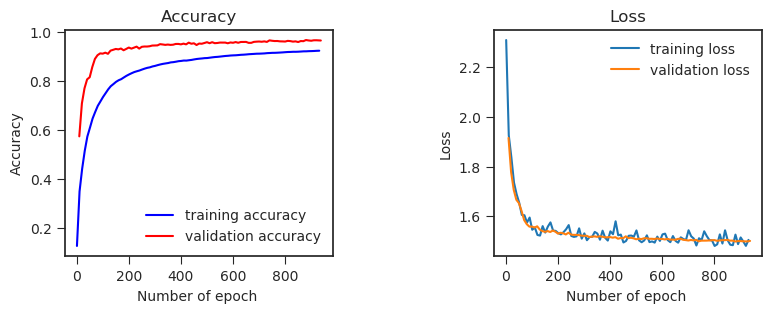

In [104]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on locally using gcloud

In [109]:
%%bash
# Use Cloud Machine Learning Engine to train the model in local file system
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords=${PWD}/'data/mnist/tfrecords_image_test/*' \
   --input_train_tfrecords=${PWD}/'data/mnist/tfrecords_image_train/*' \
   --model_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/ckpt/' \
   --saved_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c32505668>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:TF_CONFIG environment variable: {'environment': 'cloud', 'cluster': {}, 'job': {'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_test/*', '--input_train_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_train/*', '--model_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/ckpt/', '--saved_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/pt/'], 'job_name': 'trainer.task'}, 'task': {}}
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:RunConfig initialized for Distribute Coordinator with INDEPENDENT_WORKER mode
INFO:

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

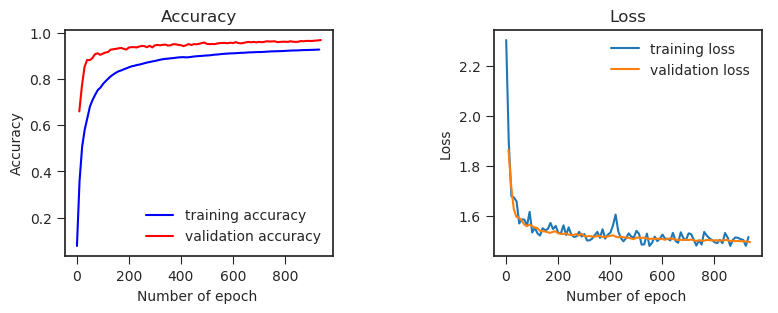

In [110]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on GCP using gcloud

In [630]:
!gsutil ls gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-9.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecord_image_test/
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecords_image_test/


In [111]:
!pwd

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [653]:
%%bash
echo "gs://${PROJECT}/mnist/tfrecords/image_test/"

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/


In [658]:
%%bash
# Clear Cloud Storage bucket and copy the tfrecords files to Cloud Storage bucket
echo $BUCKET
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_train/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_test/*" "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_train/*" "gs://${BUCKET}/mnist/tfrecords/image_train/"

ml-productive-pipeline-53122


Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords#1553517828053883...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords#1553517828015615...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords#1553517827285785...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords#1553517827539125...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords#1553517828118894...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords#1553517827486017...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords#1553517827901783...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords#1553517828044041...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords#1553517827140683...
Removing gs://ml-productive-pipeline

In [696]:
%%bash
OUTDIR="gs://${BUCKET}/${MODEL_NAME}/${TRAINING_DIR}"
JOBNAME=${MODEL_NAME}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
# Clear the Cloud Storage Bucket used for the training job
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket="gs://$BUCKET" \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   --python-version='3.5' \
   --labels=$RESOURCE_LABELS \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords= "gs://${BUCKET}/mnist/tfrecords/image_test/*" \
   --input_train_tfrecords="gs://${BUCKET}/mnist/tfrecords/image_train/*" \
   --model_dir=$OUTDIR \
   --saved_dir=$OUTDIR   

gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained us-central1 model_mnist_v1_190325_152158
jobId: model_mnist_v1_190325_152158
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [model_mnist_v1_190325_152158] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe model_mnist_v1_190325_152158

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158


In [697]:
! gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158

INFO	2019-03-25 16:22:04 +0100	service		Validating job requirements...
INFO	2019-03-25 16:22:04 +0100	service		Job creation request has been successfully validated.
INFO	2019-03-25 16:22:05 +0100	service		Job model_mnist_v1_190325_152158 is queued.
INFO	2019-03-25 16:22:05 +0100	service		Waiting for job to be provisioned.
INFO	2019-03-25 16:22:08 +0100	service		Waiting for training program to start.
INFO	2019-03-25 16:23:44 +0100	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz"],  "python_module": "trainer.task",  "args": ["--epoch\u003d2", "--step_per_epoch\u003d468", "--input_test_tfrecords\u003d", "gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*", "--input_train_tfrecords\u003dgs://ml-productive-pipeline-53122/mni

INFO	2019-03-25 16:24:28 +0100	master-replica-0		TF_CONFIG environment variable: {'task': {'cloud': 'qe913eccfb8ab063b-ml', 'index': 0, 'type': 'master'}, 'cluster': {'master': ['127.0.0.1:2222']}, 'environment': 'cloud', 'job': {'runtime_version': '1.12', 'python_module': 'trainer.task', 'package_uris': ['gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz'], 'python_version': '3.5', 'job_dir': 'gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', 'region': 'us-central1', 'run_on_raw_vm': True, 'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=', 'gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*', '--input_train_tfrecords=gs://ml-productive-pipeline-53122/mnist/tfrecords/image_train/*', '--model_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', '--saved_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained',

INFO	2019-03-25 16:25:09 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:25:09 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:25:15 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527507'/saved_model.pb
INFO	2019-03-25 16:25:19 +0100	master-replica-0		Saving checkpoints for 40 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:25:26
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/mo

INFO	2019-03-25 16:26:26 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-100
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:26:26 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:26:31 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527585'/saved_model.pb
INFO	2019-03-25 16:26:34 +0100	master-replica-0		global_step/sec: 1.00519
INFO	2019-03-25 16:26:34 +0100	master-replica-0		loss = 0.31793758, step = 100 (99.484 sec)
INFO	2019-03-25 16:26:34 +0100	master-replica-0		Saving checkpoints for 120 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:26:41 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:26:41

INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-180
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:27:40 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:27:45 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527658'/saved_model.pb
INFO	2019-03-25 16:27:48 

INFO	2019-03-25 16:28:46 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:28:46
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:28:47
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving dict for global step 260: accuracy = 0.0, global_step = 260, loss = 0.0
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 260: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Done calling model_

INFO	2019-03-25 16:29:54 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:29:54
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving dict for global step 340: accuracy = 0.0, global_step = 340, loss = 0.0
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 340: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-340
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export 

INFO	2019-03-25 16:30:48 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527844'/saved_model.pb
INFO	2019-03-25 16:30:51 +0100	master-replica-0		global_step/sec: 1.22815
INFO	2019-03-25 16:30:51 +0100	master-replica-0		loss = 0.047065996, step = 400 (81.423 sec)
INFO	2019-03-25 16:30:51 +0100	master-replica-0		Saving checkpoints for 420 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:30:57
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/mode

INFO	2019-03-25 16:31:54 +0100	master-replica-0		Saving checkpoints for 500 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:32:00 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:32:01
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-500
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:32:02
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Saving dict for global

INFO	2019-03-25 16:32:49 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:32:53 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527968'/saved_model.pb
INFO	2019-03-25 16:32:56 +0100	master-replica-0		Saving checkpoints for 580 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:08 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527984'/saved_model.pb
INFO	2019-03-25 16:33:11 +0100	master-replica-0		Saving checkpoints for 600 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:33:17 +0100	m

INFO	2019-03-25 16:34:02 +0100	master-replica-0		Saving dict for global step 660: accuracy = 0.0, global_step = 660, loss = 0.0
INFO	2019-03-25 16:34:05 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 660: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-660
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Restori

INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving dict for global step 740: accuracy = 0.0, global_step = 740, loss = 0.0
INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 740: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-740
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Restori

INFO	2019-03-25 16:36:02 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:36:02
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving dict for global step 820: accuracy = 0.0, global_step = 820, loss = 0.0
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 820: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-820
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	20

INFO	2019-03-25 16:37:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-900
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:37:08 +0100	master-replica-0		SavedModel written to:

INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-

## Visualization

In [ ]:
#for e in tf.train.summary_iterator('/tmp/mnist_convnet_model/events.out.tfevents.1553025053.Fabien-Tarrades-MacBook-Pro.local'):
for e in tf.train.summary_iterator('results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local'):
    for v in e.summary.value:
        #if v.tag == 'accuracy':
        #print(v.simple_value)
        print(v)

In [736]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np

def load_data_tensorboard(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}
    
    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []
        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)
        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [739]:
#history_eval=load_data_tensorboard(FLAGS.model_dir+'/eval')
history_train=load_data_tensorboard(FLAGS.model_dir)

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local


In [740]:
history_eval.keys(), history_train.keys()

(dict_keys(['accuracy', 'loss']), dict_keys(['global_step/sec', 'loss_1']))

In [574]:
len(history_train['accuracy_1'][1]), len(history_eval['accuracy'][1]), len(history_train['global_step/sec'][1])

(100, 100, 19)

In [575]:
history_eval['accuracy'][0]

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000])

In [741]:
history_train['accuracy_1'][0]

KeyError: 'accuracy_1'

Loss:
  - loss [training dataset]: 1.526
  - loss [validation dataset: 1.496

Accuracy:
  - accuracy [training dataset]: 92.73%
  - accuracy [validation dataset: 96.68%


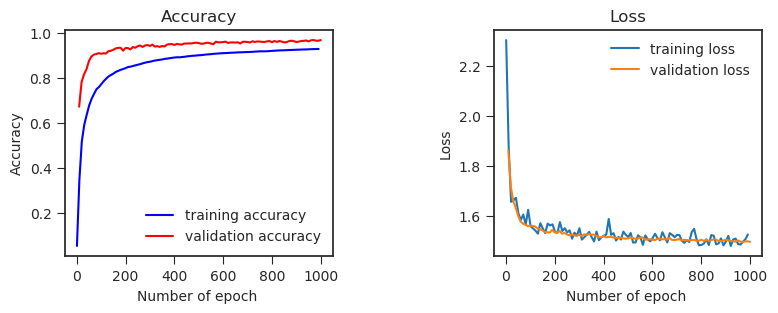

In [577]:
# plot the training loss and accuracy
fig = plt.figure(figsize=(9, 3), dpi=100)
plt.subplots_adjust(wspace=0.6)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(history_train['accuracy_1'][0], history_train['accuracy_1'][1], 'b', label='training accuracy')
ax1.plot(history_eval['accuracy'][0], history_eval['accuracy'][1], 'r', label='validation accuracy');
ax1.set_title('Accuracy')
ax1.set_xlabel("Number of epoch ")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="best")

ax2.plot(history_train['loss'][0], history_train['loss'][1], label="training loss")
ax2.plot(history_eval['loss'][0], history_eval['loss'][1], label="validation loss")
ax2.set_title("Loss")
ax2.set_xlabel("Number of epoch ")
ax2.set_ylabel("Loss")
ax2.legend(loc="best");

print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(history_train['loss'][1][-1]))
print('  - loss [validation dataset: {0:.3f}'.format(history_eval['loss'][1][-1]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100 * history_train['accuracy_1'][1][-1]))
print('  - accuracy [validation dataset: {:.2f}%'.format(100 * history_eval['accuracy'][1][-1]))

### Check the output created during the training
https://medium.com/@prasadpal107/saving-freezing-optimizing-for-inference-restoring-of-tensorflow-models-b4146deb21b5  
- creating a keras model will create the **keras** folder 
- **checkpoint**, text file that contain all checkpoint information, like model ckpt file name and path
- **model.ckpt-xxx.meta** and **model.ckpt-xxx.data-yyyyy-of-zzzzz** and **model.ckpt-xxx.index** file created for each model  
  .ckpt-xxx.meta contains the complete graph. It includes GraphDef, SaverDef, and so on  
  .ckpt-xxx.data contains the values of variables(weights, biases, placeholders, gradients, hyper-parameters etc)   
  .ckpt-xxx.index is a table where each key is the name of a tensor and its value is a serialized BundleEntryProto 
- **graph.pbtxt** holds a network of nodes, each representing one operation, connected to each other as inputs and outputs (graph structure)
- **events.out.tfevents.xxxxxxxxxx** which contain information that TensorBoard uses to create visualizations

Meta files holds ,more than just the structure of the graph like MetaInfoDef , GraphDef SaverDef , CollectionDef . Whereas .pbtxt files holds only the structure of the graph.

In [100]:
for file in glob.glob(FLAGS.model_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

keras
checkpoint
model.ckpt-940.data-00000-of-00001
model.ckpt-1000.data-00000-of-00001
model.ckpt-920.meta
model.ckpt-940.meta
model.ckpt-1000.meta
model.ckpt-960.meta
events.out.tfevents.1552739145.Fabien-Tarrades-MacBook-Pro.local
graph.pbtxt
model.ckpt-980.meta
model.ckpt-960.data-00000-of-00001
model.ckpt-920.index
model.ckpt-920.data-00000-of-00001
eval
model.ckpt-980.data-00000-of-00001
export
model.ckpt-960.index
model.ckpt-980.index
model.ckpt-940.index
model.ckpt-1000.index


### TensorBoard

In [39]:
print('Tensorflow logs will be saved here:\n',FLAGS.model_dir)

Tensorflow logs will be saved here:
 results/Models/Mnist/tf_1_12/estimator/ckpt/


In [243]:
for file in glob.glob(FLAGS.model_dir+'*events.out.tfevents.*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local


In [228]:
tensorboard_command='tensorboard --logdir "'+FLAGS.model_dir+'"'

In [42]:
print('In a separate shell with the same env activated (need Tensoflow and TensorBoard)')
print('  copy and pate the command below without ">>":')
print('  >>',tensorboard_command)


In a separate shell with the same env activated (need Tensoflow and TensorBoard)
  copy and pate the command below without ">>":
  >> tensorboard --logdir "results/Models/Mnist/tf_1_12/estimator/ckpt/"


### Looking at the output of the TimeHistory

In [ ]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

In [ ]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

## Accuracy and losses

### Training dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_train_tfrecords+'/train*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.TRAIN,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [training dataset]: {}'.format(score['global_step']))

### Testing dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_test_tfrecords+'/test*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.EVAL,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [testing dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [testing dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [testing dataset]: {}'.format(score['global_step']))

## Test

In [ ]:
# Rebuild the model
predictions = model_fn(features, labels, tf.estimator.ModeKeys.EVAL).predictions

# Manually load the latest checkpoint
saver = tf.train.Saver()
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('/my/directory')
    saver.restore(sess, ckpt.model_checkpoint_path)

    # Loop through the batches and store predictions and labels
    prediction_values = []
    label_values = []
    while True:
        try:
            preds, lbls = sess.run([predictions, labels])
            prediction_values += preds
            label_values += lbls
        except tf.errors.OutOfRangeError:
            break
    # store prediction_values and label_values somewhere

## Prediction 

### Method 1

In [ ]:
testing_dataset = mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                           FLAGS,
                                                           mode=tf.estimator.ModeKeys.EVAL)

In [ ]:
iterator = testing_dataset.make_one_shot_iterator()
# next_element
features, labels = iterator.get_next()

In [ ]:
n=0

n_iter=10
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

In [ ]:
predictions=list(estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.PREDICT)))

In [ ]:
len(predictions), len(x_test)

In [ ]:
output_layer=model_opt_tf.output_names[0]

In [ ]:
for i in range(10):
    prediction_array = predictions[i][output_layer]
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)

### Method 2

In [ ]:
preds_iter=estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.EVAL,
                                                                                                  batch_size=len(x_test)))

In [ ]:
i=0
for pred in list(itertools.islice(preds_iter, 5)):
    prediction_array = pred['dense_2']
    predicted_label = np.argmax(prediction_array)
    print(prediction_array)
    print(i)
    if i==0:
        print('--> ',pred.keys())
    print()
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)
    i+=1

### Keras's model checks

In [ ]:
model_opt_tf.summary()

In [ ]:
model_opt_tf.input_names

In [ ]:
model_opt_tf.output_names

In [ ]:
output_layer=model_opt_tf.output_names[0]

### Estimator's model checks

In [ ]:
estimator_train_model.get_variable_names()

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[0]).shape

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[1]).shape

In [ ]:
estimator_train_model.latest_checkpoint()

## Model serving using Keras, tf.estimator and tf.data.dataset

In [ ]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

In [ ]:
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

In [ ]:
model_opt_tf.input_names

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_2_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_2_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
if not os.path.exists(FLAGS.saved_dir):
    os.makedirs(FLAGS.saved_dir)

In [ ]:
# Option 2: Only export predict mode
estimator_train_model.export_saved_model(os.path.abspath(FLAGS.saved_dir), 
                                         serving_input_receiver_fn=serving_input_receiver_fn)

In [495]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

**Update the model id in the path below with the correct one from above i.e'1549040172'**

In [504]:
model_tag='1549054852'
os.environ['MODEL_FOR_SERVING']='results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141'#FLAGS.saved_dir+model_tag+'/'

In [502]:
!ls results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141

saved_model.pb variables


In [ ]:
# replace the folder name below with the one from above i.e '1549040172'
for file in glob.glob(FLAGS.saved_dir+model_tag+'/*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

## Check the saved model before serving 

In [493]:
tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY,

('serving_default',)

In [505]:
! saved_model_cli show --dir $MODEL_FOR_SERVING --tag serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: Placeholder:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['classes'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: ArgMax:0
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: Softmax:0
Method name is: tensorflow/serving/predict


## Use Cloud ML Engine

### Checking gcloud installation (SDK)

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

### Create a input json file and string

Input needed to get prediction using ml-engine an option --json-instances: 'dense_2_input' for each new entry

In [ ]:
input_prediction=x_test[0:3]

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_gcloud.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    for el in data:
        instance = {'dense_2_input': el}
        json.dump(instance, f , sort_keys=True)
        f.write("\n")

Input needed to get prediction using ml-engine and cURL

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_cURL.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    tmp={}
    list_tmp=[]
    for el in data:
        tmp['dense_2_input']=el
        list_tmp.append(tmp)
    instance = {"instances": list_tmp}    
    json.dump(instance, f , sort_keys=True)
    f.write("\n")

In [ ]:
input_predict_request = json.dumps({"signature_name": "serving_default", "instances": input_prediction.tolist()})

display example

In [ ]:
def show(img, title):
    plt.figure()
    plt.imshow(img.reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [ ]:
for i in range(1):
    show(x_test[i],'Test dataset, true label: '+str(np.argmax(y_test[i])))

### Test the model inference using gcloud locally

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

In [ ]:
!gcloud ml-engine local predict --model-dir $MODEL_FOR_SERVING --json-instances ../data/input_predict_gcloud.json 

### Deploy the model using Cloud ML Engine
- https://cloud.google.com/ml-engine/docs/v1/predict-request
- https://cloud.google.com/ml-engine/docs/tensorflow/online-predict#requesting_predictions

In [ ]:
os.environ['PROJECT']=subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['MODEL']='mnist'
os.environ['BUCKET']='gs://'+os.environ['PROJECT']
os.environ['VERSION']='v2'

In [ ]:
# gsutil need python 2.7
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda/bin/python'

In [ ]:
!gsutil cp -r $MODEL_FOR_SERVING $BUCKET/model_dir_tmp/

In [ ]:
!gcloud ml-engine models list

when creating the model for the first time

create a version and store the model

In [ ]:
!gcloud ml-engine versions create ${VERSION} \
--model ${MODEL} \
--origin=${BUCKET}/model_dir_tmp/1549054852 \
--runtime-version=1.12 \
--staging-bucket=${BUCKET}

#### Checking the list of model in ML-Engine

In [ ]:
!gcloud ml-engine models list

In [ ]:
 !gcloud ml-engine versions list --model mnist

#### Testing our model using ML-Engine

In [ ]:
!gcloud ml-engine predict --model=${MODEL} --version=${VERSION} --json-instances ../data/input_predict_gcloud.json

#### Testing using RESTful API 
- https://www.tensorflow.org/serving/api_rest  
RESTful API is an application program interface (API) that uses HTTP requests to GET, PUT, POST and DELETE data (Json)

Use cURL

In [ ]:
!curl https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION} \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \

In [ ]:
!curl -X POST \
https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION}:predict \
-H "Content-Type: application/json" \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-d @../data/input_predict_cURL.json 

Use python and requests

In [ ]:
url = 'https://ml.googleapis.com/v1/projects/'+os.environ['PROJECT']+'/models/'+os.environ['MODEL']+'/versions/'+os.environ['VERSION']+':predict'

headers = {
    'Content-Type': 'application/json',
    'Authorization':  'Bearer {}'.format(subprocess.run('gcloud auth print-access-token', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', ''))
}

json_response = requests.post(url=url, data=input_predict_request, headers=headers)
json.loads(json_response.text)

In [ ]:
predictions = json.loads(json_response.text)['predictions']

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))

#### Testing using gRPC API 
- https://cloud.google.com/endpoints/docs/grpc/about-grpc  
gRPC is a high performance, open-source universal RPC framework, developed by Google. In gRPC, a client application can directly call methods on a server application on a different machine as if it was a local object, making it easier to create distributed applications and services (Protobuf)

In [ ]:
# to do

## Debug Python environment

In [ ]:
!python -c "import tensorflow as tf; print(tf.GIT_VERSION, tf.VERSION)"

In [ ]:
!conda list

In [ ]:
## Reload the model and make evaluation using Keras

In [ ]:
reload_model_opt_keras=tf.keras.models.load_model(FLAGS.model_dir_keras+'keras_model.h5')

In [ ]:
score = reload_model_opt_keras.evaluate(x_train, 
                                        y_train, 
                                        verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
### Evaluate the model using Keras and tf.data.dataset

In [ ]:
score = model_opt_keras.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
score = model_opt_keras.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))